In [1]:
import re
import os
import sys
sys.path.insert(0, '../')
import time

import numpy as np
rng = np.random.RandomState(0)

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
import astropy.constants as constants
from astropy.stats import mad_std
import astropy.units as u

import pandas as pd

import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc

from src import GlobularCluster
from src.plot import LogNorm, AsinhNorm
from src.utils import profile_binning, clip_quantile_nd
from src.cluster import DBSCAN_Clustering

from src.plot import colorbar_non_mappable

%load_ext autoreload
%autoreload 2

In [45]:
drct = r"../data/"
gc_name = "NGC_104_47Tuc"

GC = GlobularCluster.from_directory(gc_name, drct)
GC.table[:10]

x,y,pmx,pmy,pmx_e,pmy_e,pm_corr,g_mag,bp_rp,filter,memberprob,r,pm
deg,deg,mas / yr,mas / yr,mas / yr,mas / yr,,mag,mag,,,deg,mas / yr
float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64
-0.1348291,-0.4223898,4.965001,-1.958991,0.4321207,0.2950536,-0.2759779,18.64288,0.9655228,1,0.9608296,0.4433869972730932,5.337497603566862
-0.1460269,-0.5634596,4.810706,-2.849002,0.4770243,0.3784877,-0.1997244,19.0192,0.9610672,1,0.9145111,0.5820743735604326,5.591037883473872
-0.201078,-0.5594672,6.021084,-2.886704,0.428852,0.3393994,-0.2042322,19.02555,0.9025326,1,0.9122948,0.5945047602499413,6.677313270969994
-0.1740618,-0.4439956,5.61163,-2.356492,0.3257529,0.2321778,-0.1048194,18.35304,0.8021355,1,0.9837987,0.4768957989315905,6.086332705575995
-0.1392909,-0.4596016,5.0425,-2.515524,0.435556,0.3233984,-0.1713472,18.85314,0.9282074,1,0.9776442,0.4802453389106135,5.635127970558965
-0.1411725,-0.459395,5.549176,-2.330111,0.298539,0.2271065,-0.1144845,18.2724,0.8452454,1,0.9846143,0.48059696293386,6.018535665034893
-0.1246436,-0.4506446,5.153496,-2.146417,0.1321777,0.1013947,-0.1101597,16.95577,0.9907436,1,0.9847023,0.46756452231763695,5.5826182889308305
-0.3280258,-0.5654799,5.216442,-2.177776,0.3041002,0.229164,-0.2205339,18.27854,0.8409805,1,0.9621208,0.653734229461522,5.652784751389354


In [46]:
GC.summary

Name,ra,dec,dist,vlos,vloserr,sigma,rmax,pmra,pmdec,pmra_e,pmdec_e,pmcorr,nstar,rscale,pmdisp,pmscale,pmscale_e,pm,sc
,deg,deg,kpc,km / s,km / s,km / s,arcmin,mas / yr,mas / yr,mas / yr,mas / yr,,,arcmin,mas / yr,mas / yr,mas / yr,mas / yr,"kpc,kpc,kpc"
str15,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object
NGC_104_47Tuc,6.02363,-72.081,4.5,-17.2,0.2,12.2,40.0,5.237,-2.524,0.039,0.039,-0.002,23917.2,18.3,0.418,0.399,0.016,5.8134967962492246,"1.3768803520135557,0.14529010919422547,-4.281715927103217"


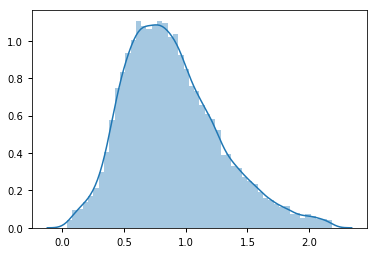

In [48]:
sns.distplot(GC.r)

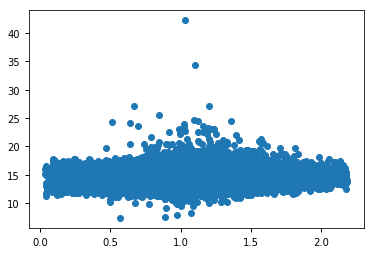

In [50]:
plt.scatter(GC.r, GC.pm)

Text(0, 0.5, 'PM')

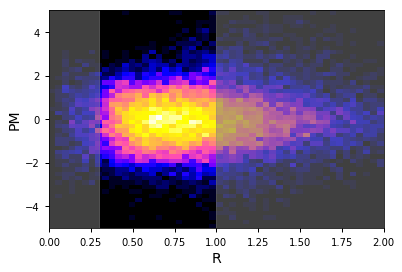

In [70]:
H, xb, yb, _ = plt.hist2d(GC.r, GC.pm-GC.pm.mean(), bins=50, range=[[0,2],[-5,5]], norm=AsinhNorm(), cmap="gnuplot2")

plt.axvspan(0, 0.3, 0, color="gray", alpha=0.5)
plt.axvspan(1, 2, 0, color="gray", alpha=0.5)
plt.xlabel("R")  # normalized
plt.ylabel("PM") # normalized

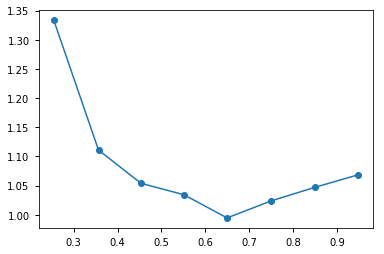

In [186]:
bins=np.linspace(0.2, 1, 9)
r_rbin, z_rbin, z_bins = profile_binning(GC.r, GC.pm, bins=bins, plot=False)
plt.plot(r_rbin, [mad_std(z_bins[i]['pm']) for i in range(len(z_bins))],'o-')

### Read all GCs

In [118]:
import os
gc_names = [fname.split('.')[0] for fname in os.listdir(os.path.join(drct, 'gcs'))]

GCs = [GlobularCluster.from_directory(name, drct) for name in gc_names[:100]]

In [149]:
r_all = np.concatenate([gc.r for gc in GCs if len(gc.table)>2000])
pm_all = np.concatenate([gc.pm - gc.pm.mean() for gc in GCs if len(gc.table)>2000])
print(r_all.shape)

(103394,)


Text(0.5, 0, 'R (normed)')

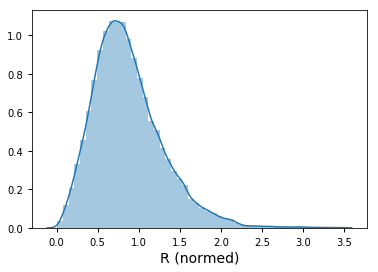

In [150]:
sns.distplot(r_all)
plt.xlabel("R (normed)")

Text(0.5, 0, 'PM (normed)')

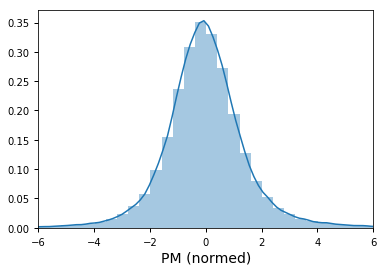

In [151]:
sns.distplot(pm_all[abs(pm_all)<10])
plt.xlim(-6,6)
plt.xlabel("PM (normed)")

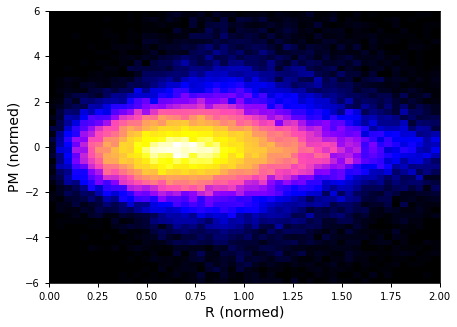

In [152]:
# display r-pm hist2d
plt.figure(figsize=(7,5))
H, xb, yb, _ = plt.hist2d(r_all, pm_all, bins=50, range=[[0,2],[-6,6]], norm=AsinhNorm(), cmap="gnuplot2")

plt.xlabel("R (normed)") # normalized
plt.ylabel("PM (normed)") # normalized
plt.show()

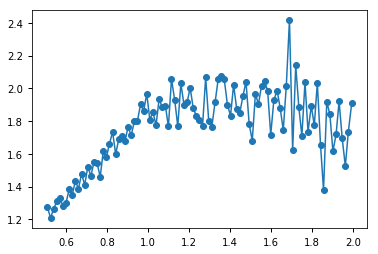

In [163]:
bins=np.linspace(0.5, 2, 100)
r_rbin, z_rbin, z_bins = profile_binning(r_all, pm_all, bins=bins, plot=False)

plt.plot(r_rbin, [np.std(z_bins[i]['pm']) for i in range(len(z_bins))],'o-')